In [1]:
import os
import numpy as np
import pandas as pd

file_dir = 'ml-100k'
file_path = os.path.join(file_dir, 'u.data')
if not os.path.isdir(file_dir):
    call(['curl', '-O', 'http://files.grouplens.org/datasets/movielens/' + file_dir + '.zip'])
    call(['unzip', file_dir + '.zip'])

names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(file_path, sep = '\t', names = names)
print('data dimension: \n', data.shape)
data.head()

data dimension: 
 (100000, 4)


user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

In [2]:
from scipy.sparse import csr_matrix

def create_matrix(data, users_col, items_col, ratings_col, threshold = None):
    """
    creates the sparse user-item interaction matrix,
    if the data is not in the format where the interaction only
    contains the positive items (indicated by 1), then use the 
    threshold parameter to determine which items are considered positive
    
    Parameters
    ----------
    data : DataFrame
        implicit rating data

    users_col : str
        user column name

    items_col : str
        item column name
    
    ratings_col : str
        implicit rating column name

    threshold : int, default None
        threshold to determine whether the user-item pair is 
        a positive feedback

    Returns
    -------
    ratings : scipy sparse csr_matrix [n_users, n_items]
        user/item ratings matrix

    data : DataFrame
        the implict rating data that retains only the positive feedback
        (if specified to do so)
    """
    if threshold is not None:
        data = data[data[ratings_col] >= threshold]
        data[ratings_col] = 1
    
    for col in (items_col, users_col, ratings_col):
        data[col] = data[col].astype('category')

    ratings = csr_matrix(( data[ratings_col],
                           (data[users_col].cat.codes, data[items_col].cat.codes) ))
    ratings.eliminate_zeros()
    return ratings, data

<943x1574 sparse matrix of type '<class 'numpy.int32'>'
	with 82520 stored elements in Compressed Sparse Row format>

In [ ]:
items_col = 'item_id'
users_col = 'user_id'
ratings_col = 'rating'
threshold = 3
X, df = create_matrix(df, users_col, items_col, ratings_col, threshold)
X

In [3]:
import numpy as np
from math import ceil
from scipy.sparse import dok_matrix

def create_train_test(ratings, test_size = 0.2, seed = 1234):
    """
    split the user-item interactions matrix into train and test set
    by removing some of the interactions from every user and pretend
    that we never seen them
    TODO: parallelize the computation
    Parameters
    ----------
    ratings : scipy sparse csr_matrix
        The user-item interactions matrix
    test_size : float between 0.0 and 1.0, default 0.2
        Proportion of the user-item interactions for each user
        in the dataset to move to the test set; e.g. if set to 0.2
        and a user has 10 interactions, then 2 will be moved to the
        test set
    seed : int, default 1234
        Seed for reproducible random splitting the 
        data into train/test set
    Returns
    -------
    train : scipy sparse csr_matrix
        Training set
    test : scipy sparse csr_matrix
        Test set
    """
    assert test_size < 1.0 and test_size > 0.0

    # Dictionary Of Keys based sparse matrix is more efficient
    # for constructing sparse matrices incrementally compared with csr_matrix
    train = ratings.copy().todok()
    test = dok_matrix(train.shape, dtype = np.int32)
    
    # for all the users assign randomly chosen interactions
    # to the test and assign those interactions to zero in the training;
    # when computing the interactions to go into the test set, 
    # remember to round up the numbers (e.g. a user has 4 ratings, if the
    # test_size is 0.2, then 0.8 ratings will go to test, thus we need to
    # round up to ensure the test set gets at least 1 rating)
    rstate = np.random.RandomState(seed)
    for u in range(ratings.shape[0]):
        split_index = ratings[u].indices
        n_splits = ceil(test_size * split_index.shape[0])
        test_index = rstate.choice(split_index, size = n_splits, replace = False)
        test[u, test_index] = ratings[u, test_index]
        train[u, test_index] = 0
    
    train, test = train.tocsr(), test.tocsr()
    return train, test

In [4]:
train, test = create_train_test(ratings, test_size = 0.2, seed = 1234)
train

<943x1574 sparse matrix of type '<class 'numpy.int32'>'
	with 65641 stored elements in Compressed Sparse Row format>

In [5]:
import numpy as np
import tensorflow as tf
from tqdm import trange
from itertools import islice
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors

class TensorflowBPR:
    """
    Bayesian Personalized Ranking (BPR) for implicit feedback data

    Parameters
    ----------
    learning_rate : float, default 0.01
        learning rate for the Adam optimizer

    n_factors : int, default 20
        Number/dimension of user and item latent factors

    n_iters : int, default 15
        Number of iterations to train the algorithm
        
    n_batch_size : int, default 2000
        batch size for batch gradient descent, the original paper
        uses stochastic gradient descent (i.e., batch size of 1),
        but this can make the training unstable (very sensitive to
        learning rate)

    reg : int, default 0.01
        Regularization term for the user and item latent factors

    seed : int, default 1234
        Seed for the randomly initialized user, item latent factors

    verbose : boolean, default True
        Whether to print progress bar while training

    Attributes
    ----------
    user_factors : 2d numpy array [n_users, n_factors]
        User latent factors learnt

    item_factors : 2d numpy array [n_items, n_factors]
        Item latent factors learnt
        
    item_bias : 1d numpy array [n_items]
        bias term for the items

    history : list
        Loss function's history, can be used to evaluate
        whether the algorithm converged or not

    Reference
    ---------
    S. Rendle, C. Freudenthaler, Z. Gantner, L. Schmidt-Thieme 
    Bayesian Personalized Ranking from Implicit Feedback
    - https://arxiv.org/pdf/1205.2618.pdf
    """
    def __init__(self, learning_rate = 0.01, n_factors = 15, n_iters = 10, 
                 n_batch_size = 2000, reg = 0.01, seed = 1234, verbose = True):
        self.reg = reg
        self.seed = seed
        self.verbose = verbose
        self.n_iters = n_iters
        self.n_factors = n_factors
        self.n_batch_size = n_batch_size
        self.learning_rate = learning_rate
        
    def fit(self, ratings):
        """
        Parameters
        ----------
        ratings : scipy sparse csr_matrix [n_users, n_items]
            sparse matrix of user-item interactions
        """
        # history stores the cost, allows assessing convergence
        self.history = []
        indptr = ratings.indptr
        indices = ratings.indices
        n_users, n_items = ratings.shape
        
        # ensure batch size makes sense
        batch_size = self.n_batch_size
        if ratings.nnz < batch_size:
            batch_size = ratings.nnz
            sys.stderr.write('WARNING: Batch size is greater than number of training interactions,'
                             'switching to a batch size of {}\n'.format(X.nnz))

        batch_iters = ratings.nnz // batch_size
        
        # progress bar for training iteration if verbose is turned on
        loop = range(self.n_iters)
        if self.verbose:
            loop = trange(self.n_iters, desc = self.__class__.__name__)
        
        self._build_graph(n_users, n_items)
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            sess.run(init)

            for _ in loop:
                iteration_cost = 0.0
                for _ in range(batch_iters):
                    sampled = self._sample(n_users, n_items, indices, indptr)
                    sampled_users, sampled_pos_items, sampled_neg_items = sampled
                    feed_dict = {self._slice_u: sampled_users, 
                                 self._slice_i: sampled_pos_items, 
                                 self._slice_j: sampled_neg_items}
                    _, cost = sess.run([self._train_step, self._total_cost], feed_dict)
                    iteration_cost += cost / self.n_batch_size

                iteration_cost /= batch_iters
                self.history.append(iteration_cost)

            self.user_factors = sess.run(self.user_factors)
            self.item_factors = sess.run(self.item_factors)
            self.item_bias = sess.run(self.item_bias)
        
        return self
        
    def _sample(self, n_users, n_items, indices, indptr):
        """sample batches of random triplets u, i, j"""
        sampled_pos_items = np.zeros(self.n_batch_size, dtype = np.int32)
        sampled_neg_items = np.zeros(self.n_batch_size, dtype = np.int32)
        sampled_users = np.random.choice(n_users, size = self.n_batch_size).astype(np.int32)

        for idx, user in enumerate(sampled_users):
            pos_items = indices[ indptr[user]:indptr[user + 1] ]
            pos_item = np.random.choice(pos_items)
            neg_item = np.random.choice(n_items)
            while neg_item in pos_items:
                neg_item = np.random.choice(n_items)

            sampled_pos_items[idx] = pos_item
            sampled_neg_items[idx] = neg_item

        return sampled_users, sampled_pos_items, sampled_neg_items       
    
    def _build_graph(self, n_users, n_items):
        """build the tensorflow computational graph"""
        # initialize random weights
        self.user_factors = tf.Variable(tf.truncated_normal((n_users, self.n_factors), seed = self.seed), 
                                        name = 'user_factors')
        self.item_factors = tf.Variable(tf.truncated_normal((n_items, self.n_factors), seed = self.seed), 
                                        name = 'item_factors')
        self.item_bias = tf.Variable(tf.zeros(n_items), name = 'item_bias')

        # use tf.gather() to select a non-contiguous slice from the tensor
        # http://stackoverflow.com/questions/35146444/tensorflow-python-accessing-individual-elements-in-a-tensor
        self._slice_u = tf.placeholder(tf.int32, self.n_batch_size)
        self._slice_i = tf.placeholder(tf.int32, self.n_batch_size)
        self._slice_j = tf.placeholder(tf.int32, self.n_batch_size)
        user_u = tf.gather(self.user_factors, self._slice_u)
        item_i = tf.gather(self.item_factors, self._slice_i)
        item_j = tf.gather(self.item_factors, self._slice_j)
        bias_i = tf.gather(self.item_bias, self._slice_i)
        bias_j = tf.gather(self.item_bias, self._slice_j)
        
        # decompose the estimator, compute the difference between
        # the score of the positive items i and negative items j
        x_ui = tf.diag_part( tf.matmul(user_u, tf.transpose(item_i)) )
        x_uj = tf.diag_part( tf.matmul(user_u, tf.transpose(item_j)) )
        x_uij = bias_i - bias_j + x_ui - x_uj

        # minimize the cost
        cost_u = self.reg * tf.reduce_sum(user_u ** 2)
        cost_i = self.reg * tf.reduce_sum(item_i ** 2) + tf.reduce_sum(bias_i ** 2)
        cost_j = self.reg * tf.reduce_sum(item_j ** 2) + tf.reduce_sum(bias_j ** 2)
        cost_uij = tf.reduce_sum( tf.log(tf.nn.sigmoid(x_uij)) )
        self._total_cost = cost_u + cost_i + cost_j - cost_uij
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self._train_step = optimizer.minimize(self._total_cost)
        return self

    def predict(self):
        """
        Obtain the predicted ratings for every users and items
        by doing a dot product of the learnt user and item vectors.
        The result will be cached to avoid re-computing 
        it every time we call predict, thus there will
        only be an overhead the first time we call it.
        Note, ideally you probably don't need to compute 
        this as it returns a dense matrix and may take
        up huge amounts of memory for large datasets
        """
        if not self._predicted:
            self._get_prediction()
            self._predicted = True

        return self._pred

    def _get_prediction(self):
        """Predicted ratings (dot product of user and item vectors)"""
        self._pred = self.user_factors.dot(self.item_factors.T) + self.item_bias
        return self

    def _predict_user(self, user):
        """
        returns the predicted ratings for the specified user,
        this is mainly used in computing evaluation metric,
        where we avoid computing the whole predicted rating matrix
        
        TODO : do we even need this in the class?
        """
        user_pred = self.user_factors[user].dot(self.item_factors.T) + self.item_bias
        return user_pred
    
    def recommend(self, ratings, N = 5, user_ids = None):
        """
        Returns the top N ranked items for given user id,
        excluding the ones that the user already liked
        
        Parameters
        ----------
        ratings : scipy sparse csr_matrix [n_users, n_items]
            sparse matrix of user-item interactions 
        
        N : int
            top-N similar items' N
            
        user_ids : 1d iterator, e.g. list or numpy array
            users' id that we wish to find top-N recommended for
        
        Returns
        -------
        recommendation : 2d numpy array [number of query users_ids, N]
            each row is the top-N ranked item for each query user
        """
        if user_ids is not None:
            recommendation = np.zeros((len(user_ids), N))
            for idx, user in enumerate(user_ids):
                top_n = self._recommend_user(ratings, user, N)
                recommendation[idx] = top_n
        else:
            n_users = ratings.shape[0]
            recommendation = np.zeros((n_users, N))
            for user in range(n_users):
                top_n = self._recommend_user(ratings, user, N)
                recommendation[user] = top_n

        return recommendation

    def _recommend_user(self, ratings, user, N):
        """the top-N ranked items for a given user"""
        scores = self._predict_user(user)

        # compute the top N items, removing the items that the user already liked
        # from the result and ensure that we don't get out of bounds error when 
        # we ask for more recommendations than that are available
        liked = set(ratings[user].indices)
        count = N + len(liked)
        if count < scores.shape[0]:

            # when trying to obtain the top-N indices from the score,
            # using argpartition to retrieve the top-N indices in 
            # unsorted order and then sort them will be faster than doing
            # straight up argort on the entire score
            # http://stackoverflow.com/questions/42184499/cannot-understand-numpy-argpartition-output
            ids = np.argpartition(scores, -count)[-count:]
            best_ids = np.argsort(scores[ids])[::-1]
            best = ids[best_ids]
        else:
            best = np.argsort(scores)[::-1]

        top_n = list( islice((rec for rec in best if rec not in liked), N) )
        return top_n
    
    def get_similar_items(self, N = 5, item_ids = None):
        """
        return the top N similar items for itemid, where
        cosine distance is used as the distance metric
        
        Parameters
        ----------
        N : int
            top-N similar items' N
            
        item_ids : 1d iterator, e.g. list or numpy array
            the item ids that we wish to find the similar items
            of, the default None will compute the similar items
            for all the items
        
        Returns
        -------
        similar_items : 2d numpy array [number of query item_ids, N]
            each row is the top-N most similar item id for each
            query item id
        """
        # cosine distance is proportional to normalized euclidean distance,
        # thus we normalize the item vectors and use euclidean metric so
        # we can use the more efficient kd-tree for nearest neighbor search;
        # also the item will always to nearest to itself, so we add 1 to 
        # get an additional nearest item and remove itself at the end
        normed_item_factors = normalize(self.item_factors)
        knn = NearestNeighbors(n_neighbors = N + 1, metric = 'euclidean')
        knn.fit(normed_item_factors)

        # returns a distance, index tuple,
        # we don't actually need the distance
        if item_ids is not None:
            normed_item_factors = normed_item_factors[item_ids]

        _, items = knn.kneighbors(normed_item_factors)
        similar_items = items[:, 1:]
        return similar_items

In [6]:
bpr_params = {
    'n_factors': 20,
    'learning_rate': 0.05,
    'n_iters': 10,
    'reg': 0.01,
    'n_batch_size': 2000 
}

tf_bpr = TensorflowBPR(**bpr_params)
tf_bpr.fit(train)

TensorflowBPR: 100%|██████████| 10/10 [00:30<00:00,  2.93s/it]


In [7]:
from sklearn.metrics import roc_auc_score

def auc_score(model, ratings):
    auc = 0.0
    n_users, n_items = ratings.shape
    for user, row in enumerate(ratings):
        y_pred = model._predict_user(user)
        y_true = np.zeros(n_items, dtype = np.int32)
        y_true[row.indices] = 1
        auc += roc_auc_score(y_true, y_pred)

    auc /= n_users
    return auc

In [8]:
print(auc_score(tf_bpr, train))
print(auc_score(tf_bpr, test))

0.946753849062
0.898517343117


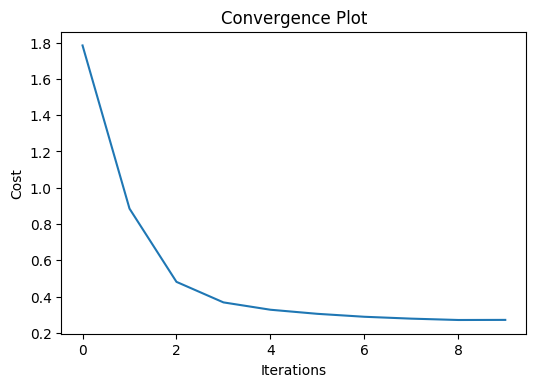

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['font.size'] = 10

plt.plot(tf_bpr.history)
plt.title('Convergence Plot')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [10]:
hi

NameError: name 'hi' is not defined

In [ ]:
n_factors = 10
n_users, n_items = train.shape
reg = 0.25

n_iters = 10
n_batch_size = 2000 # should be smaller than train.nnz
seed = 1234
learning_rate = 0.05
n_iters = 10
batch_iters = train.nnz // n_batch_size